In [87]:
# 1. Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import warnings
warnings.filterwarnings('ignore')
import os
from src.utils.metrics import obtener_ruta_app

In [88]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


In [89]:
def cargar_datos(archivo_csv):
    """
    Carga los datos desde un archivo CSV con fecha como índice
    """
    df = pd.read_csv(archivo_csv, parse_dates=['fecha'], index_col='fecha')
    df = df.sort_index()  # Asegurar orden cronológico
    print(f"Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
    print(f"Rango de fechas: {df.index.min()} a {df.index.max()}")
    return df

In [90]:
base_path = obtener_ruta_app("TemplateAgroIA")
file_path = os.path.join(base_path, "data", "processed", "rnn", "rnn_produccion.csv")
df = cargar_datos(file_path)

Datos cargados: 630 filas, 11 columnas
Rango de fechas: 2015-01-01 00:00:00 a 2025-06-01 00:00:00


In [109]:
df_pivot = df.reset_index().pivot_table(
    index='fecha', columns='canton_id', values='produccion', aggfunc='sum'
).resample('MS').sum()



In [110]:
def visualizar_serie(df, columna='produccion'):
    """
    Visualiza la serie temporal de producción
    """
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[columna], linewidth=2)
    plt.title(f'Serie Temporal de {columna.capitalize()}', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel(f'{columna.capitalize()}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Estadísticas descriptivas
    print(f"\nEstadísticas de {columna}:")
    print(df[columna].describe())

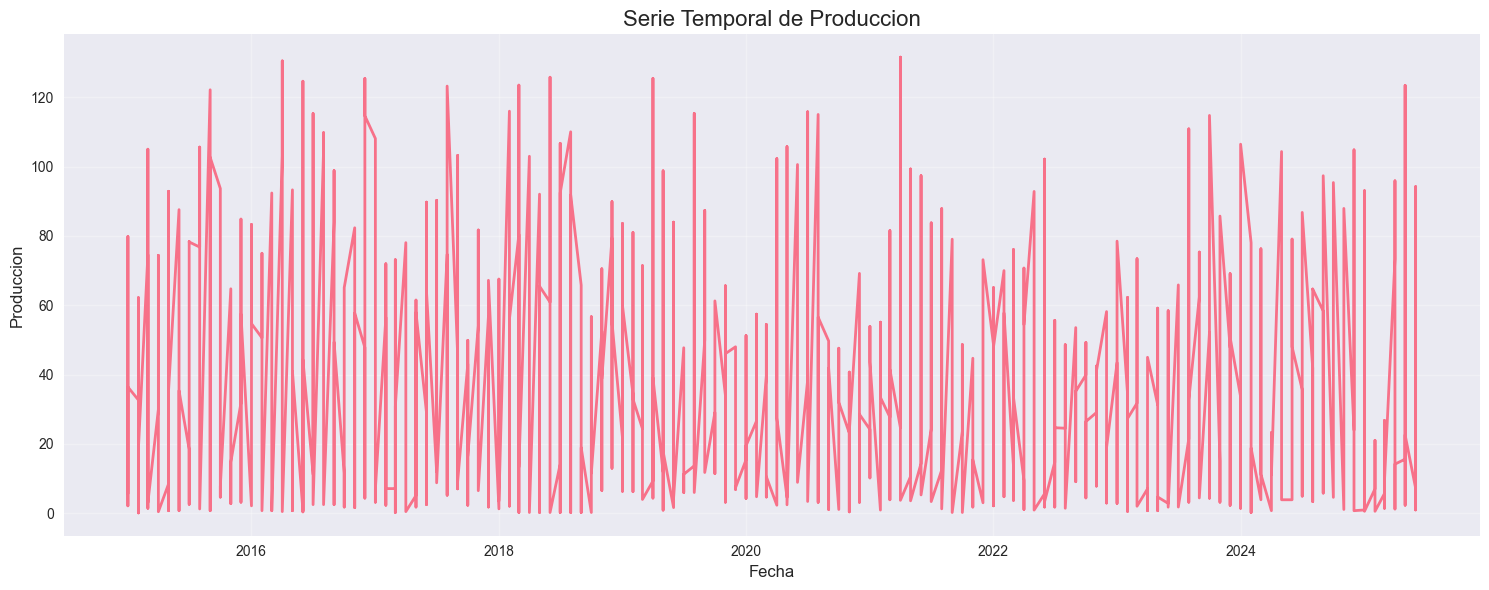


Estadísticas de produccion:
count    630.000000
mean      37.972632
std       33.477779
min        0.049000
25%        7.070000
50%       31.850000
75%       58.397500
max      131.635000
Name: produccion, dtype: float64


In [111]:
visualizar_serie(df)

In [112]:
def dividir_train_test_multivariado(df_pivot, meses_test=12):
    data = df_pivot.values
    split_point = len(data) - meses_test

    train_data = data[:split_point]
    test_data = data[split_point:]

    print(f"Datos de entrenamiento: {train_data.shape}")
    print(f"Datos de prueba: {test_data.shape}")

    return train_data, test_data, split_point


In [113]:
train_data, test_data, split_point = dividir_train_test_multivariado(df, meses_test=12)


Datos de entrenamiento: (618, 11)
Datos de prueba: (12, 11)


In [114]:
def escalar_datos_multivariado(train_data, test_data):
    from sklearn.preprocessing import MinMaxScaler

    scalers = {}
    train_scaled = np.zeros_like(train_data)
    test_scaled = np.zeros_like(test_data)

    for i in range(train_data.shape[1]):
        scaler = MinMaxScaler()
        train_scaled[:, i] = scaler.fit_transform(train_data[:, i].reshape(-1, 1)).flatten()
        test_scaled[:, i] = scaler.transform(test_data[:, i].reshape(-1, 1)).flatten()
        scalers[i] = scaler

    return train_scaled, test_scaled, scalers



In [115]:
train_scaled, test_scaled, scaler = escalar_datos_multivariado(train_data, test_data)

In [116]:
def crear_generadores_multivariado(train_scaled, test_scaled, length=6, batch_size=32, target_col=0):
    """
    Crea generadores para modelo multivariado con salida univariada.
    target_col: índice de la columna que queremos predecir (ejemplo: 0)
    """

    X_train = train_scaled  # todas las variables
    y_train = train_scaled[:, target_col].reshape(-1, 1)  # solo producción (columna específica)

    train_generator = TimeseriesGenerator(X_train, y_train, length=length, batch_size=batch_size)

    X_test = test_scaled
    y_test = test_scaled[:, target_col].reshape(-1, 1)

    test_generator = TimeseriesGenerator(X_test, y_test, length=length, batch_size=batch_size)

    return train_generator, test_generator



In [117]:
length = 11 # Usar 12 meses anteriores para predecir
train_generator, test_generator = crear_generadores_multivariado(train_scaled, test_scaled, length=length)

In [118]:
def crear_modelo_lstm(input_shape, units=128, dropout_rate=0.2):
    model = Sequential([
        # Bidirectional LSTM para capturar patrones en ambas direcciones
        Bidirectional(LSTM(units, return_sequences=True, input_shape=input_shape)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(units//2, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        LSTM(units//2, return_sequences=False),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        Dropout(dropout_rate),
        Dense(25, activation='relu'),
        Dense(df_pivot.shape[1])

    ])

    # Optimizador con learning rate personalizado
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [119]:
input_shape = (length, df_pivot.shape[1])
model = crear_modelo_lstm(input_shape=input_shape)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [120]:
def entrenar_modelo(model, train_generator, test_generator, epochs, patience=10):
    """
    Entrena el modelo con EarlyStopping
    """
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
        callbacks=[early_stopping],
        verbose=1
    )

    return history

In [121]:
print("\nIniciando entrenamiento...")
history = entrenar_modelo(model, train_generator, test_generator, epochs=150, patience=20)


Iniciando entrenamiento...
Epoch 1/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 5.5487 - mae: 0.8902 - val_loss: 4.5500 - val_mae: 0.6943
Epoch 2/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4732 - mae: 0.5224 - val_loss: 4.3531 - val_mae: 0.6790
Epoch 3/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4.1303 - mae: 0.4176 - val_loss: 4.1485 - val_mae: 0.6678
Epoch 4/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8844 - mae: 0.3729 - val_loss: 3.9411 - val_mae: 0.6583
Epoch 5/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.6498 - mae: 0.3372 - val_loss: 3.7305 - val_mae: 0.6479
Epoch 6/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.4308 - mae: 0.3202 - val_loss: 3.5258 - val_mae: 0.6419
Epoch 7/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2114 - mae: 0.3009 - val_loss: 3.3098 - val_mae: 0.6264
Epoch 8/150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9881 - mae: 0.2749 - val_loss: 3.0986 - val_mae: 0.6120
Epoch 9/150
19/19 ━━━━━━━━━━

In [123]:
def evaluar_modelo_multivariado(model, test_generator, scalers, df_pivot, split_point):
    predictions_scaled = model.predict(test_generator)
    # Desescalar cada columna
    predictions = np.zeros_like(predictions_scaled)
    for i in range(predictions_scaled.shape[1]):
        predictions[:, i] = scalers[i].inverse_transform(predictions_scaled[:, i].reshape(-1, 1)).flatten()

    length = test_generator.length
    real_values = df_pivot.iloc[split_point + length:].values

    # Métricas por canal (ejemplo para MAE)
    for i, col in enumerate(df_pivot.columns):
        mae = mean_absolute_error(real_values[:, i], predictions[:, i])
        print(f"MAE {col}: {mae:.4f}")

    return predictions, real_values


In [124]:
predictions, real_values = evaluar_modelo_multivariado(model, test_generator, scaler, df, split_point)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
MAE produccion: 3.1797
MAE area: 66.9464
MAE PRECTOTCORR_SUM: 169.9747
MAE RH2M: 6.6648
MAE T2M: 0.1459


IndexError: index 5 is out of bounds for axis 1 with size 5

In [125]:
print(df.tail(20)[['produccion']])

            produccion
fecha                 
2025-03-01       5.640
2025-03-01      26.740
2025-03-01       2.660
2025-03-01       1.400
2025-03-01       9.240
2025-04-01      73.339
2025-04-01      95.921
2025-04-01      22.400
2025-04-01       1.190
2025-04-01      14.140
2025-05-01      15.575
2025-05-01     101.941
2025-05-01       2.275
2025-05-01     123.480
2025-05-01      22.575
2025-06-01       7.210
2025-06-01      93.072
2025-06-01      46.130
2025-06-01       0.910
2025-06-01      94.213


In [126]:
#Guardar el modelo
base_path = obtener_ruta_app("TemplateAgroIA")
model_path = os.path.join(base_path, "models", "modelo_RNN_Papas.h5")
print("Model path:", model_path)
# Guarda el modelo
model.save(model_path)
print("Modelo guardado con éxito.")

Model path: C:\TemplateAgroIA\models\modelo_RNN_Papas.h5
Modelo guardado con éxito.


In [127]:
def forecast_futuro(model, df, scaler, length=12, pasos_futuros=6):
    """
    Realiza predicciones futuras
    """
    # Obtener los últimos valores para iniciar el forecast
    last_sequence = df['produccion'].tail(length).values.reshape(-1, 1)
    last_sequence_scaled = scaler.transform(last_sequence)

    forecast = []
    current_sequence = last_sequence_scaled.copy()

    for _ in range(pasos_futuros):
        # Predecir siguiente valor
        next_pred = model.predict(current_sequence.reshape(1, length, 1), verbose=0)
        forecast.append(next_pred[0, 0])

        # Actualizar secuencia
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    # Desescalar predicciones
    forecast = np.array(forecast).reshape(-1, 1)
    forecast_unscaled = scaler.inverse_transform(forecast)

    return forecast_unscaled.flatten()

In [128]:
forecast = forecast_futuro(model, df, scaler, length=length, pasos_futuros=6)
print(f"\nForecast para los próximos 6 meses:")
for i, pred in enumerate(forecast, 1):
    print(f"Mes {i}: {pred:.2f}")

AttributeError: 'dict' object has no attribute 'transform'

In [129]:

def graficar_predicciones(predictions, real_values, forecast, df, split_point, length=36, pasos_futuros=6):
    """
    Grafica solo las predicciones, valores reales y forecast
    """
    plt.figure(figsize=(16, 8))

    # Fechas para predicciones en test
    test_dates = df.index[split_point + length:]

    # Solo predicciones vs reales
    plt.plot(test_dates, real_values, label='Valores Reales', color='green', linewidth=3, marker='o')
    plt.plot(test_dates, predictions.flatten(), label='Predicciones', color='red', linewidth=3, marker='s')

    # Forecast futuro
    last_date = df.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=pasos_futuros, freq='MS')
    plt.plot(future_dates, forecast, label='Forecast Futuro', color='orange', linewidth=3, linestyle='--', marker='^')

    plt.title('Predicciones vs Valores Reales - Modelo LSTM', fontsize=16)
    plt.xlabel('Fecha', fontsize=12)
    plt.ylabel('Producción', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [130]:
graficar_predicciones(predictions, real_values, forecast, df, split_point, length, pasos_futuros=6)

NameError: name 'forecast' is not defined

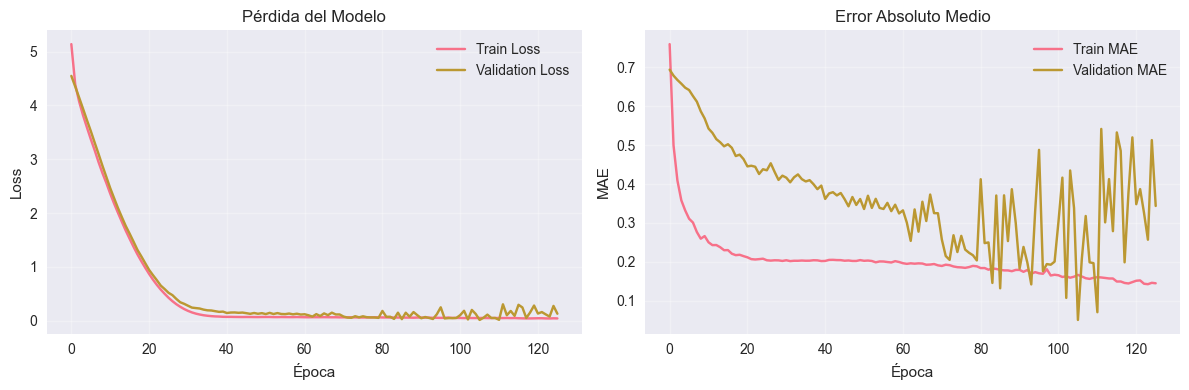

In [131]:
# Graficar curvas de entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida del Modelo')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


NameError: name 'early_stopping' is not defined

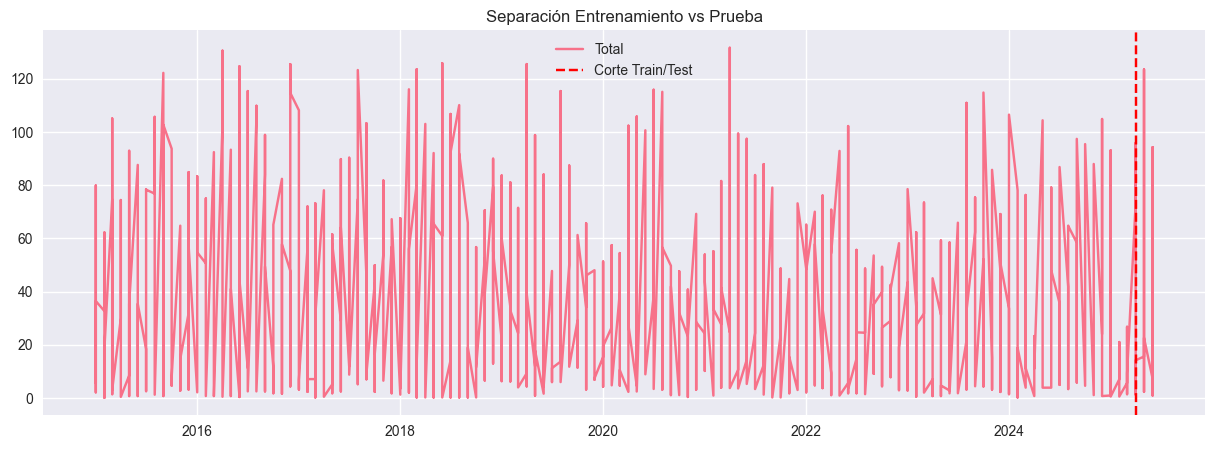

In [132]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df['produccion'], label='Total')
plt.axvline(df.index[split_point], color='red', linestyle='--', label='Corte Train/Test')
plt.legend()
plt.title("Separación Entrenamiento vs Prueba")
plt.show()
